In [1]:
# imports
import pandas as pd
import seaborn as sns    
import matplotlib.pyplot as plt
import sqlalchemy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [2]:
# constants
stopwords_file = 'Stopwords.txt'
db_name = 'sqlite:///StaterData.db'
table_name = "mortgage complaints"

In [3]:
# get stopwords
with open(stopwords_file, 'r') as f:
    stop_words = f.read().splitlines()

In [4]:
# get sqlite database via sqlalchemy
db = sqlalchemy.create_engine(db_name)

# get data from table
data = pd.read_sql_table(table_name, db)

In [5]:
# add in DataFrame
df = pd.DataFrame(data)
df.head()

,index,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,1,2023-01-10,Mortgage,Conventional home mortgage,Trouble during payment process,None,"Pennymac.com My account was set for auto pay, ...",None,"PENNYMAC LOAN SERVICES, LLC.",CA,XXXXX,None,True,Web,2023-01-31,Closed with explanation,True,True,6414919
1,2,2023-01-10,Mortgage,FHA mortgage,Struggling to pay mortgage,None,Our mortgage company ( LakeviewXXXX ) has set...,Company has responded to the consumer and the ...,"LAKEVIEW LOAN SERVICING, LLC",WA,991XX,Older American,True,Web,2023-01-27,Closed with explanation,True,True,6418853
2,3,2023-02-03,Mortgage,FHA mortgage,Struggling to pay mortgage,None,Received foreclosure notice from foreclosure a...,None,"PLANET HOME LENDING, LLC",TN,XXXXX,None,True,Web,2023-02-03,Closed with explanation,True,True,6527861
3,4,2023-01-06,Mortgage,Reverse mortgage,Trouble during payment process,None,We want to pay off our XXXXXXXX XXXX XXXX XXXX...,None,"Peer Advisors, LLC",CA,91942,None,True,Web,2023-01-26,Closed with explanation,True,True,6407628
4,8,2023-01-24,Mortgage,Conventional home mortgage,Trouble during payment process,None,We purchased our home in XX/XX/XXXX & started ...,Company has responded to the consumer and the ...,WELLS FARGO & COMPANY,FL,32259,Older American,True,Web,2023-01-24,Closed with explanation,True,True,6479592


In [6]:
# set Issue as category
df['Issue'] = df['Issue'].astype('category')

In [7]:
extracted_df = df[['Consumer complaint narrative', 'Issue']].copy()
labels = extracted_df['Issue'].cat.categories

In [8]:
le = preprocessing.LabelEncoder()
le.fit(labels)
extracted_df['Issue code'] = le.transform(extracted_df['Issue'])

In [9]:
x = extracted_df['Consumer complaint narrative']
y = extracted_df['Issue code']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=2, test_size=0.3)

In [11]:
# text to numbers
vect = CountVectorizer(stop_words=stop_words)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

In [12]:
# saga is a variant of sag. Both supports multinomial logistic regressions. more information: https://scikit-learn.org/stable/modules/linear_model.html#solvers
logregression = LogisticRegression(n_jobs=4, solver='sag', multi_class='multinomial') # 'sag' and 'saga' 

In [13]:
logregression.fit(X_train, y_train)
logregression.score(X_test, y_test)

# 0.5734310493807405 <- sag
# 0.5587736422696579 <- saga

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.5733990463084456

In [14]:
y_pred = logregression.predict(X_test)

cm = pd.DataFrame(confusion_matrix(y_test, y_pred), columns=labels, index=labels)
cm = cm.transpose()/cm.sum(axis=1)
cm

,"Application, originator, mortgage broker",Applying for a mortgage or refinancing an existing mortgage,Closing on a mortgage,Credit decision / Underwriting,Credit monitoring or identity theft protection services,Improper use of your report,Incorrect information on your report,"Loan modification,collection,foreclosure","Loan servicing, payments, escrow account",Problem with a credit reporting company's investigation into an existing problem,Problem with fraud alerts or security freezes,Settlement process and costs,Struggling to pay mortgage,Trouble during payment process,Unable to get your credit report or credit score
"Application, originator, mortgage broker",0.122103,0.024093,0.016949,0.089136,0.0000,0.056604,0.006961,0.008948,0.004990,0.000000,0.00,0.061972,0.003428,0.002583,0.0
Applying for a mortgage or refinancing an existing mortgage,0.456328,0.586671,0.197435,0.370474,0.2500,0.490566,0.078886,0.024992,0.018598,0.066667,0.25,0.115493,0.018092,0.016390,0.3
Closing on a mortgage,0.103387,0.083855,0.385708,0.058496,0.0000,0.037736,0.027842,0.015427,0.018825,0.005128,0.25,0.236620,0.011998,0.018973,0.0
Credit decision / Underwriting,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000099,0.0
Credit monitoring or identity theft protection services,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0
Improper use of your report,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0
Incorrect information on your report,0.018717,0.004068,0.001374,0.025070,0.0625,0.188679,0.176334,0.003703,0.010206,0.194872,0.00,0.005634,0.002285,0.003874,0.0
"Loan modification,collection,foreclosure",0.097148,0.025344,0.027943,0.116992,0.0000,0.000000,0.025522,0.507868,0.071898,0.025641,0.00,0.161972,0.129499,0.013211,0.0
"Loan servicing, payments, escrow account",0.081996,0.020964,0.028859,0.181058,0.0625,0.056604,0.176334,0.081456,0.384214,0.179487,0.25,0.154930,0.027423,0.049767,0.3
Problem with a credit reporting company's investigation into an existing problem,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0


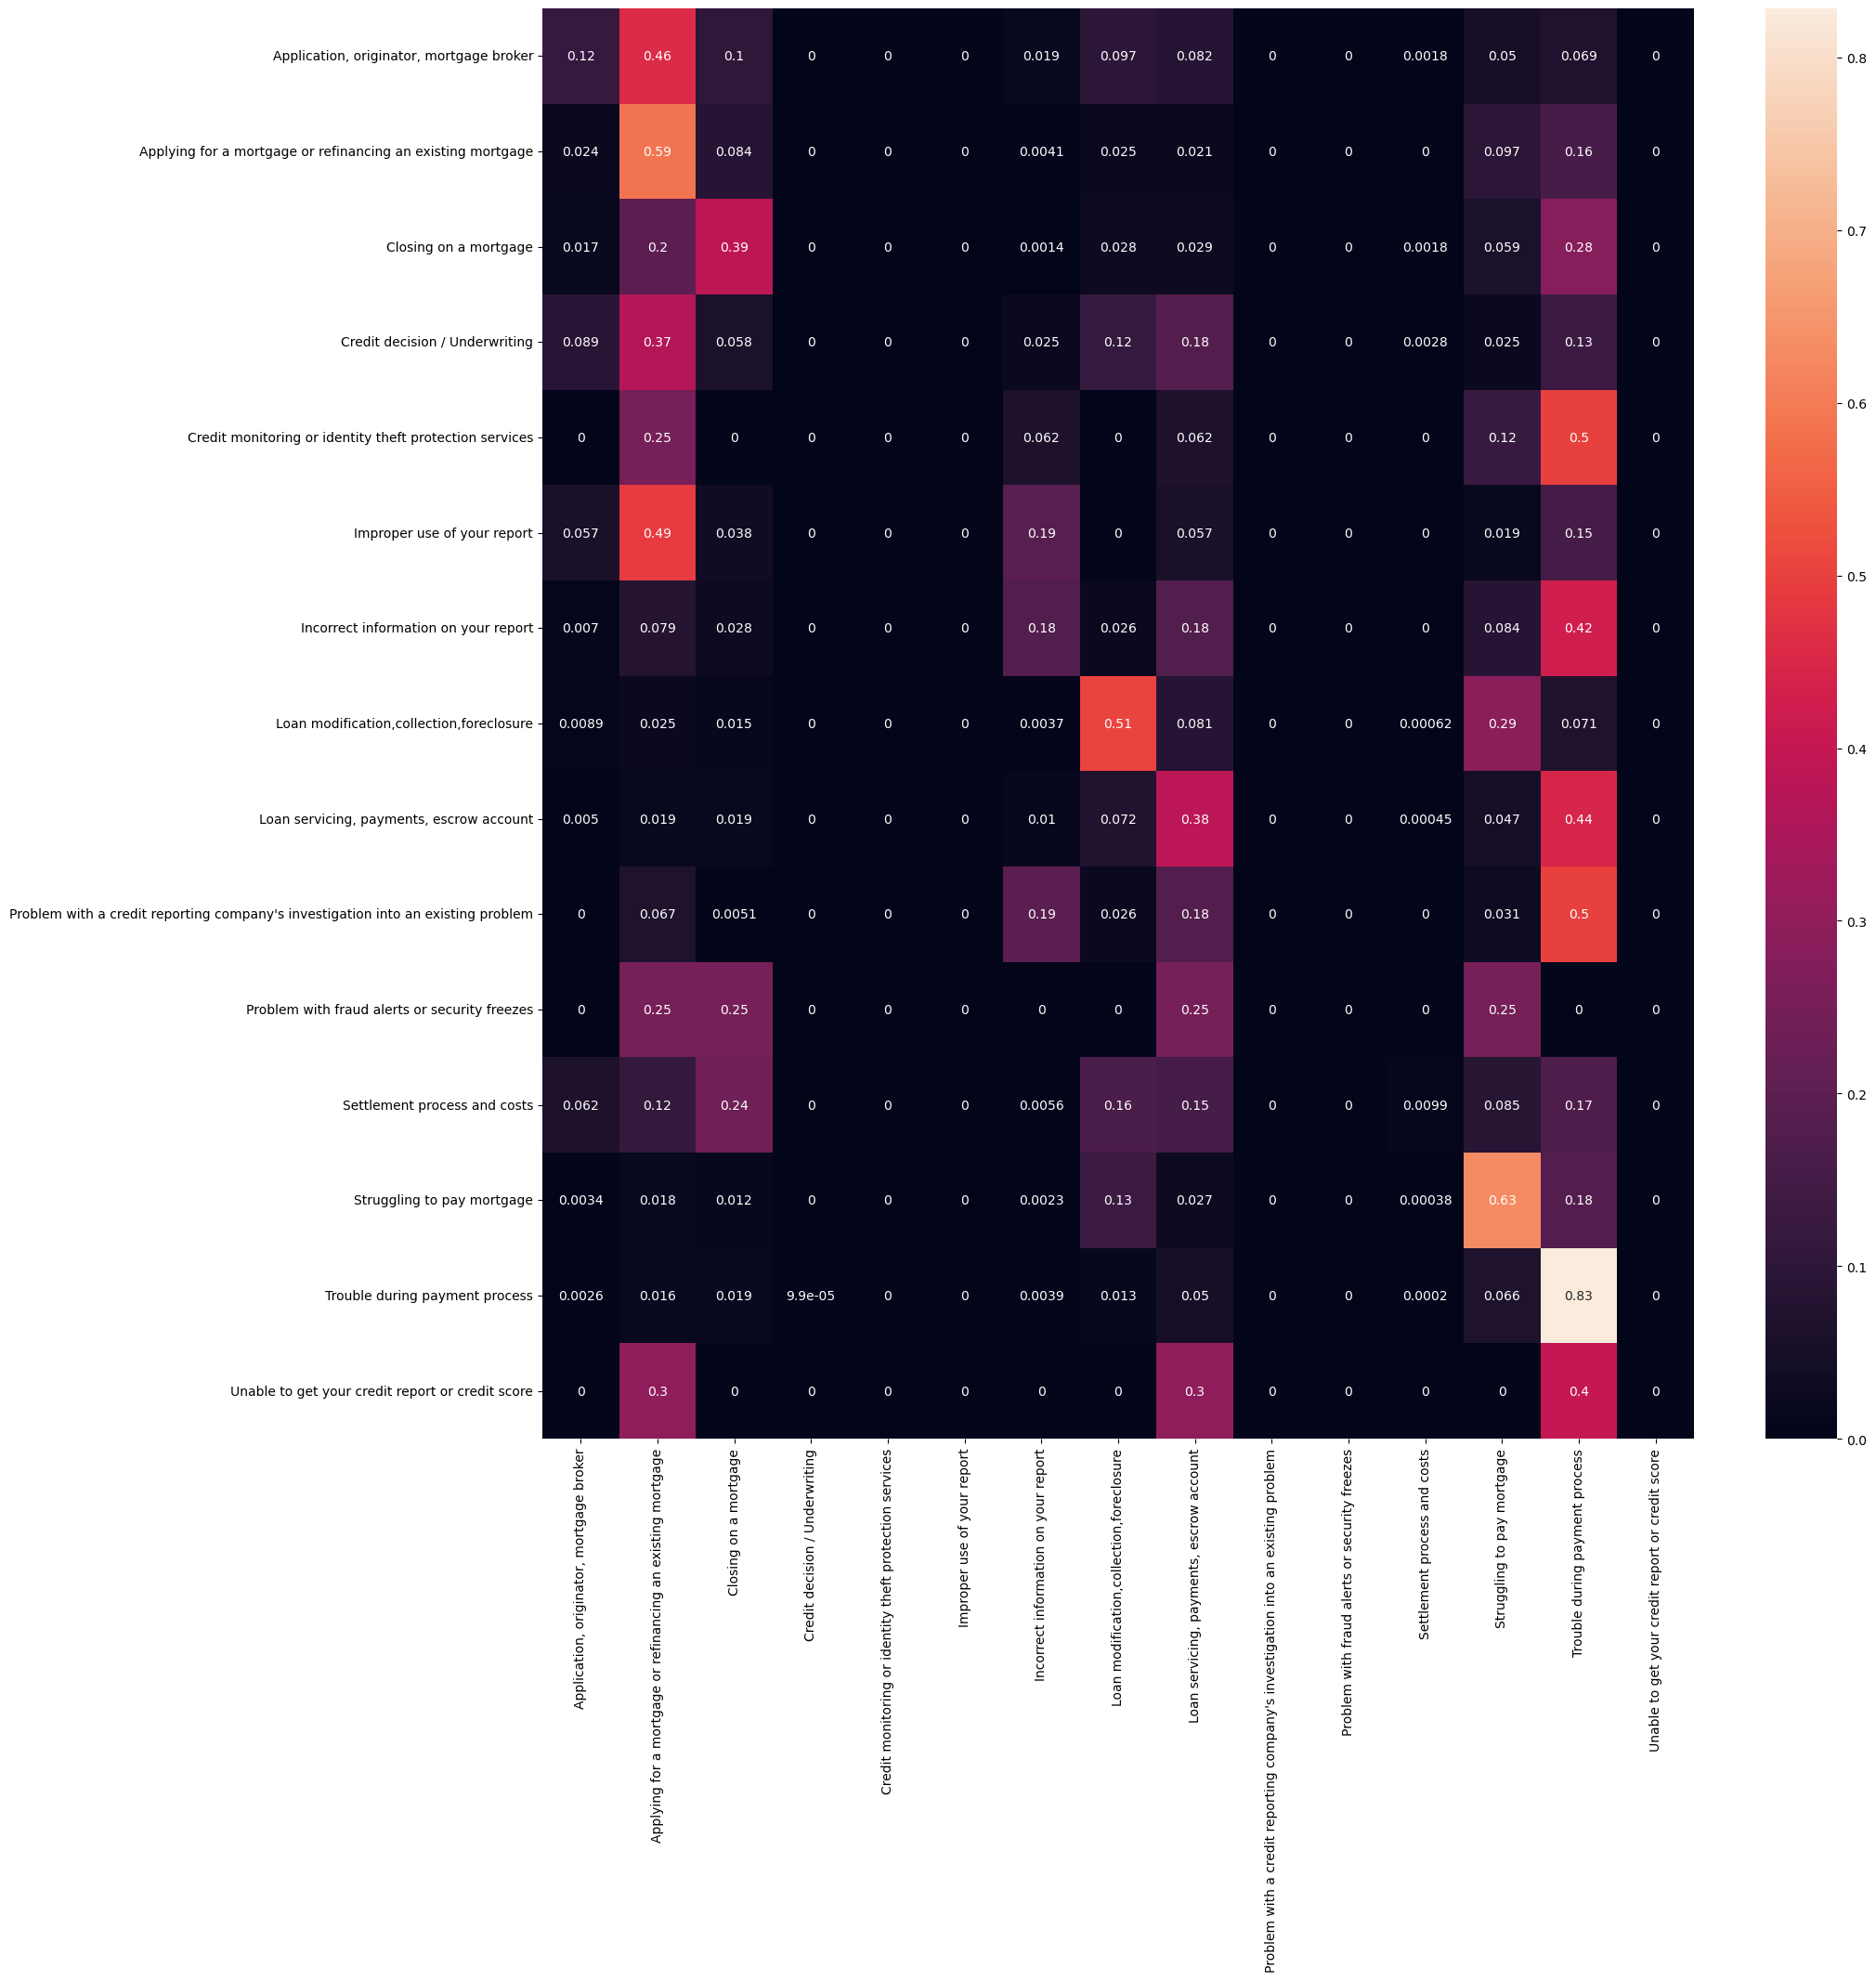

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(cm.transpose(), annot=True)
plt.show()

In [16]:
print(classification_report(y_test, y_pred, target_names=labels))

                                                                                  precision    recall  f1-score   support

                                        Application, originator, mortgage broker       0.32      0.12      0.18      1122
                     Applying for a mortgage or refinancing an existing mortgage       0.53      0.59      0.56      3196
                                                           Closing on a mortgage       0.46      0.39      0.42      2183
                                                  Credit decision / Underwriting       0.00      0.00      0.00       359
                         Credit monitoring or identity theft protection services       0.00      0.00      0.00        16
                                                     Improper use of your report       0.00      0.00      0.00        53
                                            Incorrect information on your report       0.27      0.18      0.21       431
                       

C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Cindy\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
